# XKCD's Social Seating problem

## Optimising linear seating arrangements with a pseudo-genetic algorithm, implemented in python

![XKCD comic 173](images/movie_seating.png)



Social groups are remarkably complex affairs, and on many occasions this complexity can lead to awkward situations. Randall Munroe humorously portrays one such example in XKCD #173. This comic naturally begs the question – how *do* we find the optimal arrangement?

If you're not a fan of people trying to examine non-mathematical things in mathematical terms, now would be a good time to cut your losses (at least you got to see the XKCD comic!). Otherwise, don your cringe-protection glasses and we can move on. 

The precise problem here is that the nonlinear 'social graph' has to be compressed onto a linear arrangement; as the comic points out, this is computationally hard. Nevertheless, we can attempt to do this by using a genetic algorithm of sorts. But before that, we must firstly quantify the various parameters in this problem. 



## 1. Developing the initial model

What does it mean for a seating arrangement to be optimal? I am going to take a disgustingly utilitarian approach, by simply calculating the enjoyment per individual for a certain arrangement then summing over all individuals to find the *total enjoyment*. The optimal arrangement is then just the one with the highest total enjoyment (duh).  Before going further, we must first decide on a way of describing social networks which will allow us to do this analysis. 


### Examining a social network

Following the XKCD comic, each individual be denoted by a circular node. We will consider four types of relationships between individuals: friends, one-way 'crushes', romantic relationships, and acquaintances. I'm going to slightly modify the notation of the comic though: 

<img src="images/relationship_types.png" alt = "Relationship types" style="width:400px;"\>


The major advantage of this notation is that it encourages us to only consider the *outgoing* connections from a particular individual, which will be a big simplification when we come to considering an individual's enjoyment. But it is far from perfect. For example, this notation implies that a romantic relationship is the same as a mutual crush, i.e. that I would get as much enjoyment from sitting next to my crush as I would to my partner. 

Proceeding anyway, we assign each type of outgoing arrow a weighting, corresponding to how much enjoyment an individual experiences when sitting with a person of that relation. Here is one proposed weighting:

-   Crush (arrowed line): $\text{weight} = 2$

-   Friend (solid line): $\text{weight} = 1$

-   Acquaintance (dotted line): $\text{weight} = 0.5$

-   Stranger (no line): $\text{weight} = 0$

Of course, the actual values are quite arbitrary – what matters is their relative ordering. I think it is fair to say that any individual's seating preferences follow the above list in descending order. That is, given free choice, you would enjoy most to sit next to your crush, and least enjoy sitting next to a stranger. Choosing precise weightings would require you to quantify exactly how much more you would prefer to sit with a crush than with a friend – good luck with that!


### A quick example

Now that we can *describe* a social network, let's try to calculate the total enjoyment for a seating arrangement.
We may as well use the network given in the comic. Here it is reproduced with our new notation (labelling each individual with a letter of the alphabet): 

<img src="images/xkcdgraphletters.png" alt = "the xkcd graph" style="width:400px;"\>



If this group has to sit down in a line, they will form an arrangement
that will be denoted by a sequence of letters. For example, the
arrangement *BFGHECDA* represents *F* sitting to
the right of *B*, *G* to the right of *F*, etc. For each of the
8! possible arrangements, we could calculate a total enjoyment, denoted
by $\epsilon_{\text{total}}$, which is done as follows. Consider the arrangement $ABCDEFGH$: 

<img src="images/xkcdline.png" alt = "linearised arrangement" style="width:400px;"\>


Assuming that an individual can only be affected by the individuals immediately to their left or right, each individual can have up to two outgoing connections,  which can assume values of 2, 1, 0.5, or 0 depending on the relationship. For each individual, we add up these values, then to find $\epsilon_\text{total}$ we just sum over all the individuals.

This is easy to do with just one arrangement, but we need a robust way of finding $\epsilon_{\text{total}}$ for *any* arrangement. 


## 2. Refining the model

Get ready, I am about to throw a lot of notation at you. 

- Let the number of individuals in a network be denoted by $n$. In the XKCD network, there are 8 individuals, so $n=8$.
- Each individual will be arbitrarily labelled $1, 2, 3, \ldots , n$, rather than using letters of the alphabet. 
- In order to define an individual's relationships with other members of the group, we will associate a vector $x_i$ with each individual in the group, where $x_i \in \mathbb{R}^n$. 
    - This vector contains one element for each member in the network (including itself). 
    - The $m$th entry of the vector $x_i$ encodes the enjoyment produced for individual $i$ by individual $m$. 
    - We will denote the $m$th row of the vector $x_i$ as $[i, m]$. 
	
That is a lot to take in, but hopefully this notation will become clearer with an example. Here is the XKCD network, with the letter labels replaced by numerals.


<img src="images/xkcdgraphnumbers.png" alt = "xkcd graph with numerals" style="width:400px;"\>

For the sixth individual, we have: $ x_6 = \langle 0,0,0,2,1,0,0.5,0 \rangle $. Let's break this down to make sure we are on the same page: 

-   The first three entries (and the final one) are equal to zero,
    because individual 6 has no relationship with individuals 1, 2, 3,
    and 8 (i.e they are strangers to him). We could also write $[6,1] = [6,2] = [6,3] = [6,8] = 0$.

-   The fourth entry is equal to two, because individual 6 has a crush
    on individual 4. We could also write $[6,4] = 2$. 

-   The fifth entry is equal to one, because individual 6 is friends
    with individual 5. We could also write $[6,5] = 1$.

-   The seventh entry is equal to a half, because individual 6 is an
    acquaintance of individual 7. We could also write $[6,7] = 0.5$.
	
You may notice that I neglected to mention the sixth entry of $x_6$. $[6, 6]$ represents the enjoyment produced for the sixth individual by the sixth individual. I suppose that some people enjoy themselves more when alone, but why would they go to the movie then? We will set this entry to zero. That is to say, if $i=m, [i,m] = 0$. In our model, individuals get no enjoyment from sitting next to themselves. 

We can write a vector $x_i$ for every individual in our network. After doing this, *we do not need the graph any more* – our network is fully defined by these *n* vectors! 


### The total enjoyment for a general arrangement


We will denote a general linear arrangement of individuals as 
$$u_1, u_2, u_3, \ldots, u_n$$

(earlier we had *ABCDEFGH*). You may be wondering why I have decided to add *yet another* variable – am I just trying to be novel in my notation? As it happens, there is a very important distinction between the individual's location ($u$) and the *label* of the individual ($i$). **$\mathbf{u_1}$ is not the same as individual 1**. $u_1$ could be any of the people in the network – but what matters is that this individual is in the first position of the arrangement. That is to say that the $u$ terms are a way of representing the order of the people. 

For example, 

$$\begin{align}
    u_1 &= 3 \\
    u_2 &= 7 \\
    u_3 &= 1 \\
    u_4 &= 2 \\
    u_5 &= 5  \\
    u_6 &= 8 \\
    u_7 &= 6  \\
    u_8 &= 4 
\end{align}$$

corresponds to a seating arrangement 3, 7, 1, 2, 5, 8, 6, 4 (remember, each numeral is the label of a person!). 


In order to calculate $\epsilon_\text{total}$, we need to calculate the enjoyment for each $u$ term then take the sum of all these. Because of our simplification that an individual is only affected by the
people immediately to their left or right, a neat trick is to group
the arrangement into pairs. So we will think of the arrangement as:

$$(u_1, u_2), (u_2,u_3), (u_3, u_4), \ldots, (u_{n-2}, u_{n-1}),(u_{n-1}, u_n),$$ 

where each pair of parentheses encloses the relationship between two individuals.

It is at this stage that we need to recall the previously-defined vector notation. Just as $x_6$ represents the relationship of individual 6 to the network, the vector representing individual $u_1$'s relationship to the network is $x_{u_1}$. Thus, the enjoyment produced in individual $u_1$ by individual $u_2$ can be
found by looking in the $u_2$th entry of the vector $x_{u_1}$. This subscript-within-subscript notation is very confusing, which is why we defined an alternative notation, the square-bracket notation wherein $[i, m]$ represents the $m$th row of the vector $x_i$. 

With this notation, the $u_2$th entry of the vector $x_{u_1}$ is simply written as $[u_1, u_2]$.
However, note that in the pair $(u_1, u_2)$, individual $u_1$ also
produces some enjoyment in $u_2$. Thus the total enjoyment produced
within the pair $(u_1, u_2)$ is equal to: 

$$[u_1, u_2] + [u_2, u_1]$$

Now all we need to do is sum over all the $n-1$ pairs. Therefore:

$$\epsilon_\text{total} = \sum_{r = 1}^{n-1} \left( [u_r, u_{r+1}] + [u_{r+1}, u_r] \right),$$

where $r$ is a dummy variable.

### Back to the XKCD network

Let's calculate the $\epsilon_\text{total}$ of a random arrangement. I'll choose this with my custom arrangement-randomiser:

```python
def random_arrangement():
    return [3, 2, 8, 5, 4, 6, 1, 7]
```


To begin with, we need to know the vectors $x_i$. These unfortunately have to be hard-coded based on the network. Earlier we showed the full form of $x_6$ and how we got there. Let's repeat the same process to find $x_i, i = 1,2,3,...,8$
(because $n=8$).


$$\begin{align}
    x_1 &= \langle 0,2,0,0,0,0,0,0 \rangle \\
    x_2 &= \langle 2,0,1,0,0,0,0,1 \rangle \\
    x_3 &= \langle 0,1,0,1,0,0,0,0.5 \rangle \\
    x_4 &= \langle 0,0,1,0,0.5,2,0,0 \rangle \\
    x_5 &= \langle 0,0,0,0.5,0,1,0,0 \rangle \\
    x_6 &= \langle 0,0,0,2,1,0,0.5,0 \rangle \\
    x_7 &= \langle 0,0,0,0,0,0.5,0,2 \rangle \\
    x_8 &= \langle 0,,0.5,0,0,0,1,0 \rangle
\end{align}$$


In order to calculate $\epsilon_\text{total}$, we just need to apply our formula:


$$\begin{align}
    \epsilon_\text{total} &= \sum_{r = 1}^{n-1} \left( [u_r, u_{r+1}] + [u_{r+1}, u_r] \right) \\
    &= [3, 2] + [2, 3] + [2, 8] + [8, 2] + \ldots + [1, 7] + [7, 1]  \\
    &= 1+1+1+1+0+0+0.5+0.5+2+2+0+0+0+0 \\
    &= 9
\end{align}$$

It is worth commenting on the fact that all of the above values come in identical pairs (that is, $[u_r, u_{r+1}] = [u_{r+1}, u_r]$), which is **not true** generally. However, for this particular network, there is only one asymmetrical relationship, the one-way crush between individuals 7 and 8
– and in our particular arrangement, 7 is not next to 8.

We could have found $\epsilon_\text{total}$ without our vector notation, and simply with arithmetic by looking at the linkages on the graph. However, the process that we have described in this section does not require actually looking at the networks, meaning that we can write code to do it for us. 

## 3. Optimising the arrangement


Now that we can effectively calculate $\epsilon_\text{total}$ for any given arrangement. We are ready to find the optimal arrangement.

A brute force search (i.e, calculating
$\epsilon_\text{total}$ for every possible arrangement and returning the maximum), is not feasible due to the computational complexity, which is $\Theta(n!)$. For those not familiar with Big O notation and it's variants, I'm just trying to say that it will be bloody slow.

So we need an alternative. The problem is that many optimisation algorithms rely on calculus, which requires a continuous independent variable. Our independent variable is the arrangement, which is certainly not continuous,
meaning that we cannot use many of these algorithms. How, then, do we approach this problem?


### Genetic algorithms

A genetic algorithm is a 'shortcut' optimisation method that mimics Darwinian natural selection. 

A brief summary of Darwin's theory is as follows:

1.  There is a population of **phenotypes**, individual members
    with different genetics and hence different characteristics.

2.  This variety means that certain individuals are better suited to
    their environment.

3.  The ‘fitter’ individuals survive and reproduce, passing on their
    genetic information to the next generation.

4.  During the process of reproduction, random mutations may occur,
    resulting in slight changes to the child phenotype.

5.  The process repeats, and over time, the species gets increasingly
    better adapted to the environment.

Here is an outline of the genetic algorithm to optimise the seating arrangement of our social network:

1.  There is a 'population' of different possible arrangements.

2.  Some of these arrangements have a higher $\epsilon_\text{total}$.

3.  These phenotypes survive, and some of the survivors 'reproduce' – their arrangements are somehow combined. In computer science, this step is known as the **crossover**.

4.  Random mutations occur, i.e. some arrangements may be changed
    slightly.

5.  The process repeats, and over time, the mean $\epsilon_\text{total}$ of the population should increase.



## 4. Implementing the (pseudo)-genetic algorithm in python

In this section we will write python code to find the optimum arrangement for the XKCD network, though of course we could use it for any other network. 

Let us represent our network as a list of lists, where each sublist corresponds to a vector $x_i$.


In [1]:
network = [[0, 2, 0, 0, 0, 0, 0, 0],
           [2, 0, 1, 0, 0, 0, 0, 1],
           [0, 1, 0, 1, 0, 0, 0, 0.5],
           [0, 0, 1, 0, 0.5, 2, 0, 0],
           [0, 0, 0, 0.5, 0, 1, 0, 0],
           [0, 0, 0, 2, 1, 0, 0.5, 0],
           [0, 0, 0, 0, 0, 0.5, 0, 2],
           [0, 1, 0.5, 0, 0, 0, 1, 0]]

network_size = len(network)
population_size = 16

However, don't forget that python indexing starts from zero. So to find the enjoyment that indiviudal 5 produces in individual 3, we look at `network[2][4]`, **not** `network[3][5]`. While we are at it, it is worth creating some useful global variables. 

### Generating the population

In order to generate a population, we need to know the network size (the number of individuals) and the desired population size. A good start for a population size is 16, so we will start with that.

In [48]:
import random

def generate_population(network_size, population_size):
    """
    :param network_size: the number of individuals in the network
    :param population_size: the number of different initial arrangements
    """
    # Empty list which will contain the arrangements
    population = []
    # Produce the simplest arrangement, which is just the
    # individuals in order of their index, i.e [1,2,3,4,5,6,7,8].
    test_phenotype = [i for i in range(1, network_size + 1)]

    # Shuffle the test_phenotype to generate the population
    for i in range(population_size):
        random.shuffle(test_phenotype)
        population.append(list(test_phenotype))

    return population

generate_population(network_size, population_size)

[[3, 4, 5, 6, 8, 2, 1, 7],
 [1, 5, 2, 3, 7, 8, 6, 4],
 [1, 5, 6, 3, 2, 8, 4, 7],
 [7, 2, 6, 4, 3, 1, 5, 8],
 [1, 5, 2, 4, 6, 8, 3, 7],
 [5, 6, 3, 1, 4, 7, 8, 2],
 [4, 5, 2, 1, 3, 8, 6, 7],
 [5, 8, 4, 1, 7, 6, 2, 3],
 [7, 2, 5, 1, 3, 8, 4, 6],
 [5, 3, 1, 2, 6, 7, 4, 8],
 [7, 1, 2, 4, 6, 8, 3, 5],
 [7, 8, 2, 4, 6, 1, 3, 5],
 [2, 4, 3, 7, 1, 8, 6, 5],
 [1, 8, 7, 5, 3, 6, 4, 2],
 [3, 8, 5, 7, 2, 1, 6, 4],
 [3, 1, 6, 8, 7, 4, 5, 2]]


### Evaluating a phenotype's fitness

We now need to implement a function to calculate the $\epsilon_\text{total}$ of a particular arrangement. We do this by initially setting $\epsilon_\text{total} = 0$, then cumulatively adding the contributions from each pair

In [49]:
def evaluate_etotal(arrangement):
    etotal = 0

    for r in range(network_size - 1):
        # u_r1 is meant to represent u_{r+1}
        # When defining u_r and u_r1, we subtract 1,
        # because indices in python start from zero.
        u_r = arrangement[r] - 1
        u_r1 = arrangement[r + 1] - 1

        # network[u_r][u_r1] is the same as [u_r, u_r1]
        # epair is the contribution from each pair
        epair = network[u_r][u_r1] + network[u_r1][u_r]
        etotal += epair

    return(etotal)

We can test this function on the random arrangement that we examined earlier:

In [50]:
print(evaluate_etotal([3, 2, 8, 5, 4, 6, 1, 7]))

9.0


Excellent, it agrees with our previous calculation. 


### Survival of the fittest and reproduction. 

Now that we have a funciton to measure the fitness of an arrangement, we need to find a way to remove the 'weak' individuals, leaving only survivors. Then, we need to let these survivors reproduce. But what does this mean in terms of arrangements and `etotal`s? The first part is simple: we will consider an arrangement to be *weak* if it's $\epsilon_\text{total}$ is less than the median $\epsilon_\text{total}$ (which I think is reasonable). 

However, once we have the survivors, how can we get them to 'reproduce' to form new arrangements? I thought for a long time about this, and came up with a rather unsatisfactory solution. A child needs to take some traits from the parent, while also having some differences. Therefore I decided to define a child as half of a parent's arrangement, plus the shuffle of the other half. 

Yes, I know. It's hardly reproduction – more like a glorified form of mutation, but this is why I have titled the post as a *psuedo*-genetic algorithm. If anyone can come up with a better idea for what reproduction could mean in the context of seating arrangements, I'm all ears. 

When writing this function, we also have to remember that we are eventually going to be wanting to iterate this over many generations, and see the progress.


In [51]:
import statistics

def survive_and_reproduce(population):
    # We will make a new list that stores the 'fitness' of each phenotype
    # in the population, where 'fitness' depends on the e_total.
    population_fitness = [evaluate_etotal(phenotype) for phenotype in population]

    # If a phenotype has an etotal lower than the median etotal, it is WEAK.
    median = statistics.median(population_fitness)
    weaklings = [i for i in range(len(population)) if population_fitness[i] < median]

    # Destroy the weak arrangements by excluding them from the survivor list
    survivors = [population[i] for i in range(len(population)) if i not in weaklings]

    number_removed = len(population) - len(survivors)

    # Now, the survivors 'breed'. This for loop maintains the population_size.
    for i in range(number_removed):
        # Pick a parent from the survivors
        parent = random.choice(survivors)
        # A child is the first half of a parent, plus the shuffled second half.
        estranged_father = parent[
                    int(network_size / 2):network_size]
        random.shuffle(estranged_father)
        child = parent[0:int(network_size / 2)] + estranged_father

        # The child is now part of the new generation
        survivors.append(child)

    return survivors


### Mutation

Mutations are random changes to the genetic material. With regard to seating arrangements, I will consider a mutation to be the swapping of any two members within the arrangement. 
A required parameter is the *mutation rate*, which encodes how often
mutations should occur. A value of 0.05 (which is what we shall use) means that, on average, 5 in every 100 arrangements will contain a swap.


In [52]:
def mutate(generation, mutation_rate=0.05):
    # Each member of the population has a chance of being mutated
    for i in range(len(generation)):
        # random.random() returns a float between 0 and 1,
        # so this is equivalent to a probability of the mutation_rate.
        if random.random() < mutation_rate:
            # A mutation entails two elements of the arrangement swapping.
            a, b = random.sample(range(network_size), 2)
            population[i][b], population[i][a] = population[i][a], population[i][b]

### Iteration

Evolution requires many generations to happen. In the context of our algorithm, this just means that we need to repeat the process of survival, crossover, and mutation over and over again. 

That being said, we also want to get a feel for how our algorithm is doing, so I will write a `progress` function to do that. The idea is that at every iteration, we will run `progress(generation)`, which will log the best $\epsilon_\text{total}$ of that generation, and the corresponding arrangement. 

In [53]:
progress_list = []
hall_of_fame = []


def progress(generation):
    population_fitness = [evaluate_etotal(phenotype) for phenotype in population]
    progress_list.append(max(population_fitness))
    max_location = population_fitness.index(max(population_fitness))
    hall_of_fame.append(population[max_location])

## Back to the XKCD network (for the last time)

Now that we have everything ready, we are ready to find the optimal arrangement for the XKCD network. Let's redefine the variables just to be clear. 


The optimal arrangement is:  [4, 2, 8, 7, 3, 1, 6, 5] , with an etotal of:  17


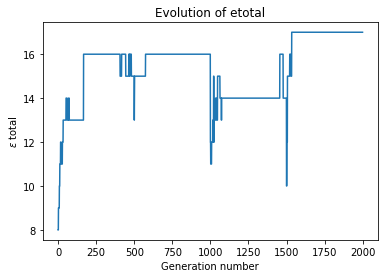

In [57]:
network = [[0, 2, 0, 0, 0, 0, 0, 0],
           [2, 0, 1, 0, 0, 0, 0, 1],
           [0, 1, 0, 1, 0, 0, 0, 0.5],
           [0, 0, 1, 0, 0.5, 2, 0, 0],
           [0, 0, 0, 0.5, 0, 1, 0, 0],
           [0, 0, 0, 2, 1, 0, 0.5, 0],
           [0, 0, 0, 0, 0, 0.5, 0, 2],
           [0, 1, 0.5, 0, 0, 0, 1, 0]]

network_size = len(network)
population_size = 16
population = generate_population(network_size, population_size)

gen_number = 500

while gen_number:
    next_generation = survive_and_reproduce(population)
    progress(next_generation)
    mutate(next_generation)
    population = next_generation

    if gen_number == 1:
        champion_location = progress_list.index(
                    max(progress_list))
        print("The optimal arrangement is: ", hall_of_fame[champion_location], ", with an etotal of: ",
              max(progress_list))

    gen_number -= 1

import matplotlib.pyplot as plt 


plt.plot(progress_list)
plt.title('Evolution of etotal')
plt.xlabel('Generation number')
plt.ylabel(r'$\epsilon$ total')
plt.show()

I ran this a number of times on my system, and plotted all the results at once.

<img src="images/many_etotal.png" alt = "plot of many etotal" style="width:700px;"\>


Notice how it is quite volatile: many generations have a lower maximum $\epsilon_\text{total}$ than their parent's generation. This is probably because our reproduction step is really just another form of mutation. That being said, all that matters is that our optimisation algorithm *hits* the maximum, it doesn't have to stay there. 


## Conclusion

So there you have it. While I haven't implemented a proper genetic algorithm, I have certainly used some of its kind of reasoning. And the results aren't so bad. 

This problem of optimising seating arrangements actually belongs to the much broader (and poorly understood) field of *combinatorial optimisation* – so it is a cousin of the famous Travelling Salesman problem, as we could interpret our investigation as trying to find the optimal route through the social network.


---

*I hope you enjoyed what turned out to be a rather long article. *All the code is on my GitHub, feel free to fork it and try out your own networks*.

*Actually, this whole post was based on an 'article' I wrote when I was younger, trying to be all professional and everything. If you're up for a laugh, you can find it [here](http://vixra.org/pdf/1605.0109v1.pdf)*
